# Baysian optimization

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import random

# Fix random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Model

### Load data

In [18]:
# Hyperparameters
batch_size = 256
epochs = 2  # Reduced for faster experimentation
subset_size = 5000

# Data transformation and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a subset of the training data
train_indices = np.random.choice(len(train_full_dataset), subset_size, replace=False)
train_dataset = Subset(train_full_dataset, train_indices)

print(f"Training on {len(train_dataset)} samples (reduced from {len(train_full_dataset)})")

# Simple data loading
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training on 5000 samples (reduced from 60000)


### Model

In [19]:
class Net(nn.Module):
    def __init__(self, conv1_channels=16, conv2_channels=32, dropout_rate=0.3, hidden_size=64):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_channels, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(conv1_channels, conv2_channels, 3, 1, padding=1)
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(conv2_channels * 14 * 14, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training function
def train(model, device, train_loader, optimizer, epoch, verbose=False):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if verbose and batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx * len(data) / len(train_loader.dataset):.0f}%)]\tLoss: {loss.item():.4f}')

# Testing function
def test(model, device, test_loader, verbose=False):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if verbose:
        print(f'Test set: Average loss: {test_loss:.4f}, '
              f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    
    return accuracy

## Optimization

In [31]:
all_results = {}

def evaluate_params(learning_rate, batch_size, dropout_rate, conv1_channels, conv2_channels, hidden_size):
    """Evaluate a set of parameters and return accuracy"""
    # Convert parameters to appropriate types
    batch_size = int(batch_size)
    conv1_channels = int(conv1_channels)
    conv2_channels = int(conv2_channels)
    hidden_size = int(hidden_size)
    
    # Create model with the given hyperparameters
    model = Net(
        conv1_channels=conv1_channels, 
        conv2_channels=conv2_channels, 
        dropout_rate=dropout_rate, 
        hidden_size=hidden_size
    ).to(device)
    
    # Initialize optimizer with the given learning rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create data loaders with the given batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Train for a fixed number of epochs
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch, verbose=False)
    
    # Get final test accuracy
    accuracy = test(model, device, test_loader, verbose=False)
    
    return accuracy

# Objective function for GPyOpt
def objective_function(x, acq_name=None):
    """
    Function to be optimized by GPyOpt's Bayesian optimization.
    Takes a numpy array of parameters and returns the negative accuracy (to minimize).
    """
    print(x)
    learning_rate = float(x[0][0])
    batch_size = 64 # float(x[0][1])
    dropout_rate = float(x[0][1])
    conv1_channels = 32 # float(x[0][3])
    conv2_channels = 64 # float(x[0][4])
    hidden_size = 256 # float(x[0][5])
    
    params = {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'conv1_channels': conv1_channels,
        'conv2_channels': conv2_channels,
        'hidden_size': hidden_size,
    }
    
    print(f"\nTesting {acq_name} with params: {params}")
    
    # Evaluate parameters
    accuracy = evaluate_params(
        learning_rate=learning_rate,
        batch_size=batch_size,
        dropout_rate=dropout_rate,
        conv1_channels=conv1_channels,
        conv2_channels=conv2_channels,
        hidden_size=hidden_size
    )
    
    print(f"{acq_name} Accuracy: {accuracy:.2f}%")
    
    # Store result
    if acq_name not in all_results:
        all_results[acq_name] = []
    
    all_results[acq_name].append({
        'iteration': len(all_results[acq_name]) + 1,
        'accuracy': accuracy,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'conv1_channels': conv1_channels,
        'conv2_channels': conv2_channels,
        'hidden_size': hidden_size
    })
    
    # Return negative accuracy for minimization
    return -accuracy

def run_random_search(bounds, n_iter=20):
    """Run random search for comparison"""
    print(f"\n{'='*50}")
    print(f"Running Random Search for {n_iter} iterations")
    print(f"{'='*50}")
    
    acq_name = "Random"
    all_results[acq_name] = []
    
    # Extract domain ranges
    param_ranges = []
    for bound in bounds:
        if bound['type'] == 'continuous':
            param_ranges.append((bound['domain'][0], bound['domain'][1]))
        else:  # discrete
            param_ranges.append(bound['domain'])
    
    for i in range(n_iter):
        # Sample random parameters
        params = []
        for j, param_range in enumerate(param_ranges):
            if isinstance(param_range, tuple) and len(param_range) == 2:
                # Continuous parameter
                params.append(np.random.uniform(param_range[0], param_range[1]))
            else:
                # Discrete parameter
                params.append(np.random.choice(param_range))
        
        # Evaluate parameters
        accuracy = evaluate_params(
            learning_rate=params[0],
            batch_size=params[1],
            dropout_rate=params[2],
            conv1_channels=params[3],
            conv2_channels=params[4],
            hidden_size=params[5]
        )
        
        print(f"Random Search Iteration {i+1}/{n_iter}: Accuracy = {accuracy:.2f}%")
        
        all_results[acq_name].append({
            'iteration': i + 1,
            'accuracy': accuracy,
            'learning_rate': params[0],
            'batch_size': params[1],
            'dropout_rate': params[2],
            'conv1_channels': params[3],
            'conv2_channels': params[4],
            'hidden_size': params[5]
        })

## Results

In [32]:
def plot_acquisition_comparison(all_results, max_iter=None):
    """Plot the performance of different acquisition functions"""
    # Create plots directory
    import os
    if not os.path.exists('plots'):
        os.makedirs('plots')
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Plot the maximum accuracy achieved so far for each acquisition function
    for acq_name, results in all_results.items():
        iterations = []
        max_accuracies = []
        current_max = 0
        
        df = pd.DataFrame(results)
        if max_iter:
            df = df[df['iteration'] <= max_iter]
        
        for _, row in df.iterrows():
            current_max = max(current_max, row['accuracy'])
            iterations.append(row['iteration'])
            max_accuracies.append(current_max)
        
        plt.plot(iterations, max_accuracies, '-o', label=acq_name, linewidth=2, markersize=6)
    
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Max Accuracy (%)', fontsize=14)
    plt.title('Comparison of Acquisition Functions for Bayesian Optimization', fontsize=16)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('plots/acquisition_function_comparison.png', dpi=300)
    plt.close()
    
    # Also save results as CSV
    all_df = pd.concat([pd.DataFrame(results).assign(method=name) for name, results in all_results.items()])
    all_df.to_csv('plots/all_optimization_results.csv', index=False)
    
    return all_df

In [33]:
# Define parameter bounds for GPyOpt Bayesian optimization
bounds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0.0001, 0.01)},
    # {'name': 'batch_size', 'type': 'discrete', 'domain': (32, 64, 128, 256, 512)},
    {'name': 'dropout_rate', 'type': 'continuous', 'domain': (0.1, 0.6)},
    # {'name': 'conv1_channels', 'type': 'discrete', 'domain': (8, 16, 24, 32)},
    # {'name': 'conv2_channels', 'type': 'discrete', 'domain': (16, 32, 48, 64)},
    # {'name': 'hidden_size', 'type': 'discrete', 'domain': (32, 64, 96, 128)}
]

# Number of iterations for each method
n_iterations = 16
# Number of initial points (for BO methods)
initial_points = 8

In [ ]:
# run_random_search(bounds, n_iter=n_iterations)


Running Random Search for 16 iterations
Random Search Iteration 1/16: Accuracy = 96.10%
Random Search Iteration 2/16: Accuracy = 79.57%
Random Search Iteration 3/16: Accuracy = 96.68%
Random Search Iteration 4/16: Accuracy = 95.71%
Random Search Iteration 5/16: Accuracy = 90.50%
Random Search Iteration 6/16: Accuracy = 90.22%
Random Search Iteration 7/16: Accuracy = 92.30%
Random Search Iteration 8/16: Accuracy = 94.83%
Random Search Iteration 9/16: Accuracy = 96.41%
Random Search Iteration 10/16: Accuracy = 95.36%
Random Search Iteration 11/16: Accuracy = 90.17%
Random Search Iteration 12/16: Accuracy = 89.16%
Random Search Iteration 13/16: Accuracy = 93.00%
Random Search Iteration 14/16: Accuracy = 95.36%
Random Search Iteration 15/16: Accuracy = 10.09%
Random Search Iteration 16/16: Accuracy = 96.59%


In [34]:
# Define acquisition functions to test
acquisition_functions = [
    ('Bayesian Optimization (BO) EI', 'EI'),    # Expected Improvement
    ('BO MPI', 'MPI'),  # Maximum Probability of Improvement
    ('BO LCB', 'LCB')   # Lower Confidence Bound
]

# Run Bayesian optimization with each acquisition function
for name, acq_type in acquisition_functions:
    print(f"\n{'='*50}")
    print(f"Starting Bayesian Optimization with {acq_type} acquisition...")
    print(f"{'='*50}")
    
    # Define objective function with the current acquisition name
    def specific_objective(x):
        return objective_function(x, acq_name=name)
    
    # Initialize optimizer
    optimizer = BayesianOptimization(
        f=specific_objective,
        domain=bounds,
        model_type='GP',
        acquisition_type=acq_type,
        acquisition_jitter=0.01,
        exact_feval=False,
        maximize=False,
        verbosity=True,
        normalize_Y=False
    )
    
    # Run optimization with initial exploration phase
    if initial_points > 0:
        optimizer.run_optimization(max_iter=0, verbosity=True, evaluations_file=f'plots/{name}_evaluations.csv')
        # Continue with optimization phase
        optimizer.run_optimization(max_iter=n_iterations-initial_points, verbosity=True, evaluations_file=f'plots/{name}_evaluations.csv')
    else:
        optimizer.run_optimization(max_iter=n_iterations, verbosity=True, evaluations_file=f'plots/{name}_evaluations.csv')

# Plot comparison of all methods
print("\nPlotting comparison of acquisition functions...")
all_df = plot_acquisition_comparison(all_results)

# Print best result for each method
print("\nBest results by method:")
for method, results in all_results.items():
    best_result = max(results, key=lambda x: x['accuracy'])
    print(f"{method}: {best_result['accuracy']:.2f}% (iteration {best_result['iteration']})")

print("\nResults saved to 'plots' directory.")


Starting Bayesian Optimization with EI acquisition...
[[0.00835331 0.48251493]]

Testing Bayesian Optimization (BO) EI with params: {'learning_rate': 0.008353308543072334, 'batch_size': 64, 'dropout_rate': 0.4825149296051985, 'conv1_channels': 32, 'conv2_channels': 64, 'hidden_size': 256}
Bayesian Optimization (BO) EI Accuracy: 11.35%
[[0.00607354 0.26173607]]

Testing Bayesian Optimization (BO) EI with params: {'learning_rate': 0.0060735384041124395, 'batch_size': 64, 'dropout_rate': 0.26173606630205926, 'conv1_channels': 32, 'conv2_channels': 64, 'hidden_size': 256}
Bayesian Optimization (BO) EI Accuracy: 11.35%
[[0.00312284 0.27410789]]

Testing Bayesian Optimization (BO) EI with params: {'learning_rate': 0.0031228368229820626, 'batch_size': 64, 'dropout_rate': 0.27410788872334846, 'conv1_channels': 32, 'conv2_channels': 64, 'hidden_size': 256}
Bayesian Optimization (BO) EI Accuracy: 96.20%
[[0.00472794 0.55991784]]

Testing Bayesian Optimization (BO) EI with params: {'learning_rat

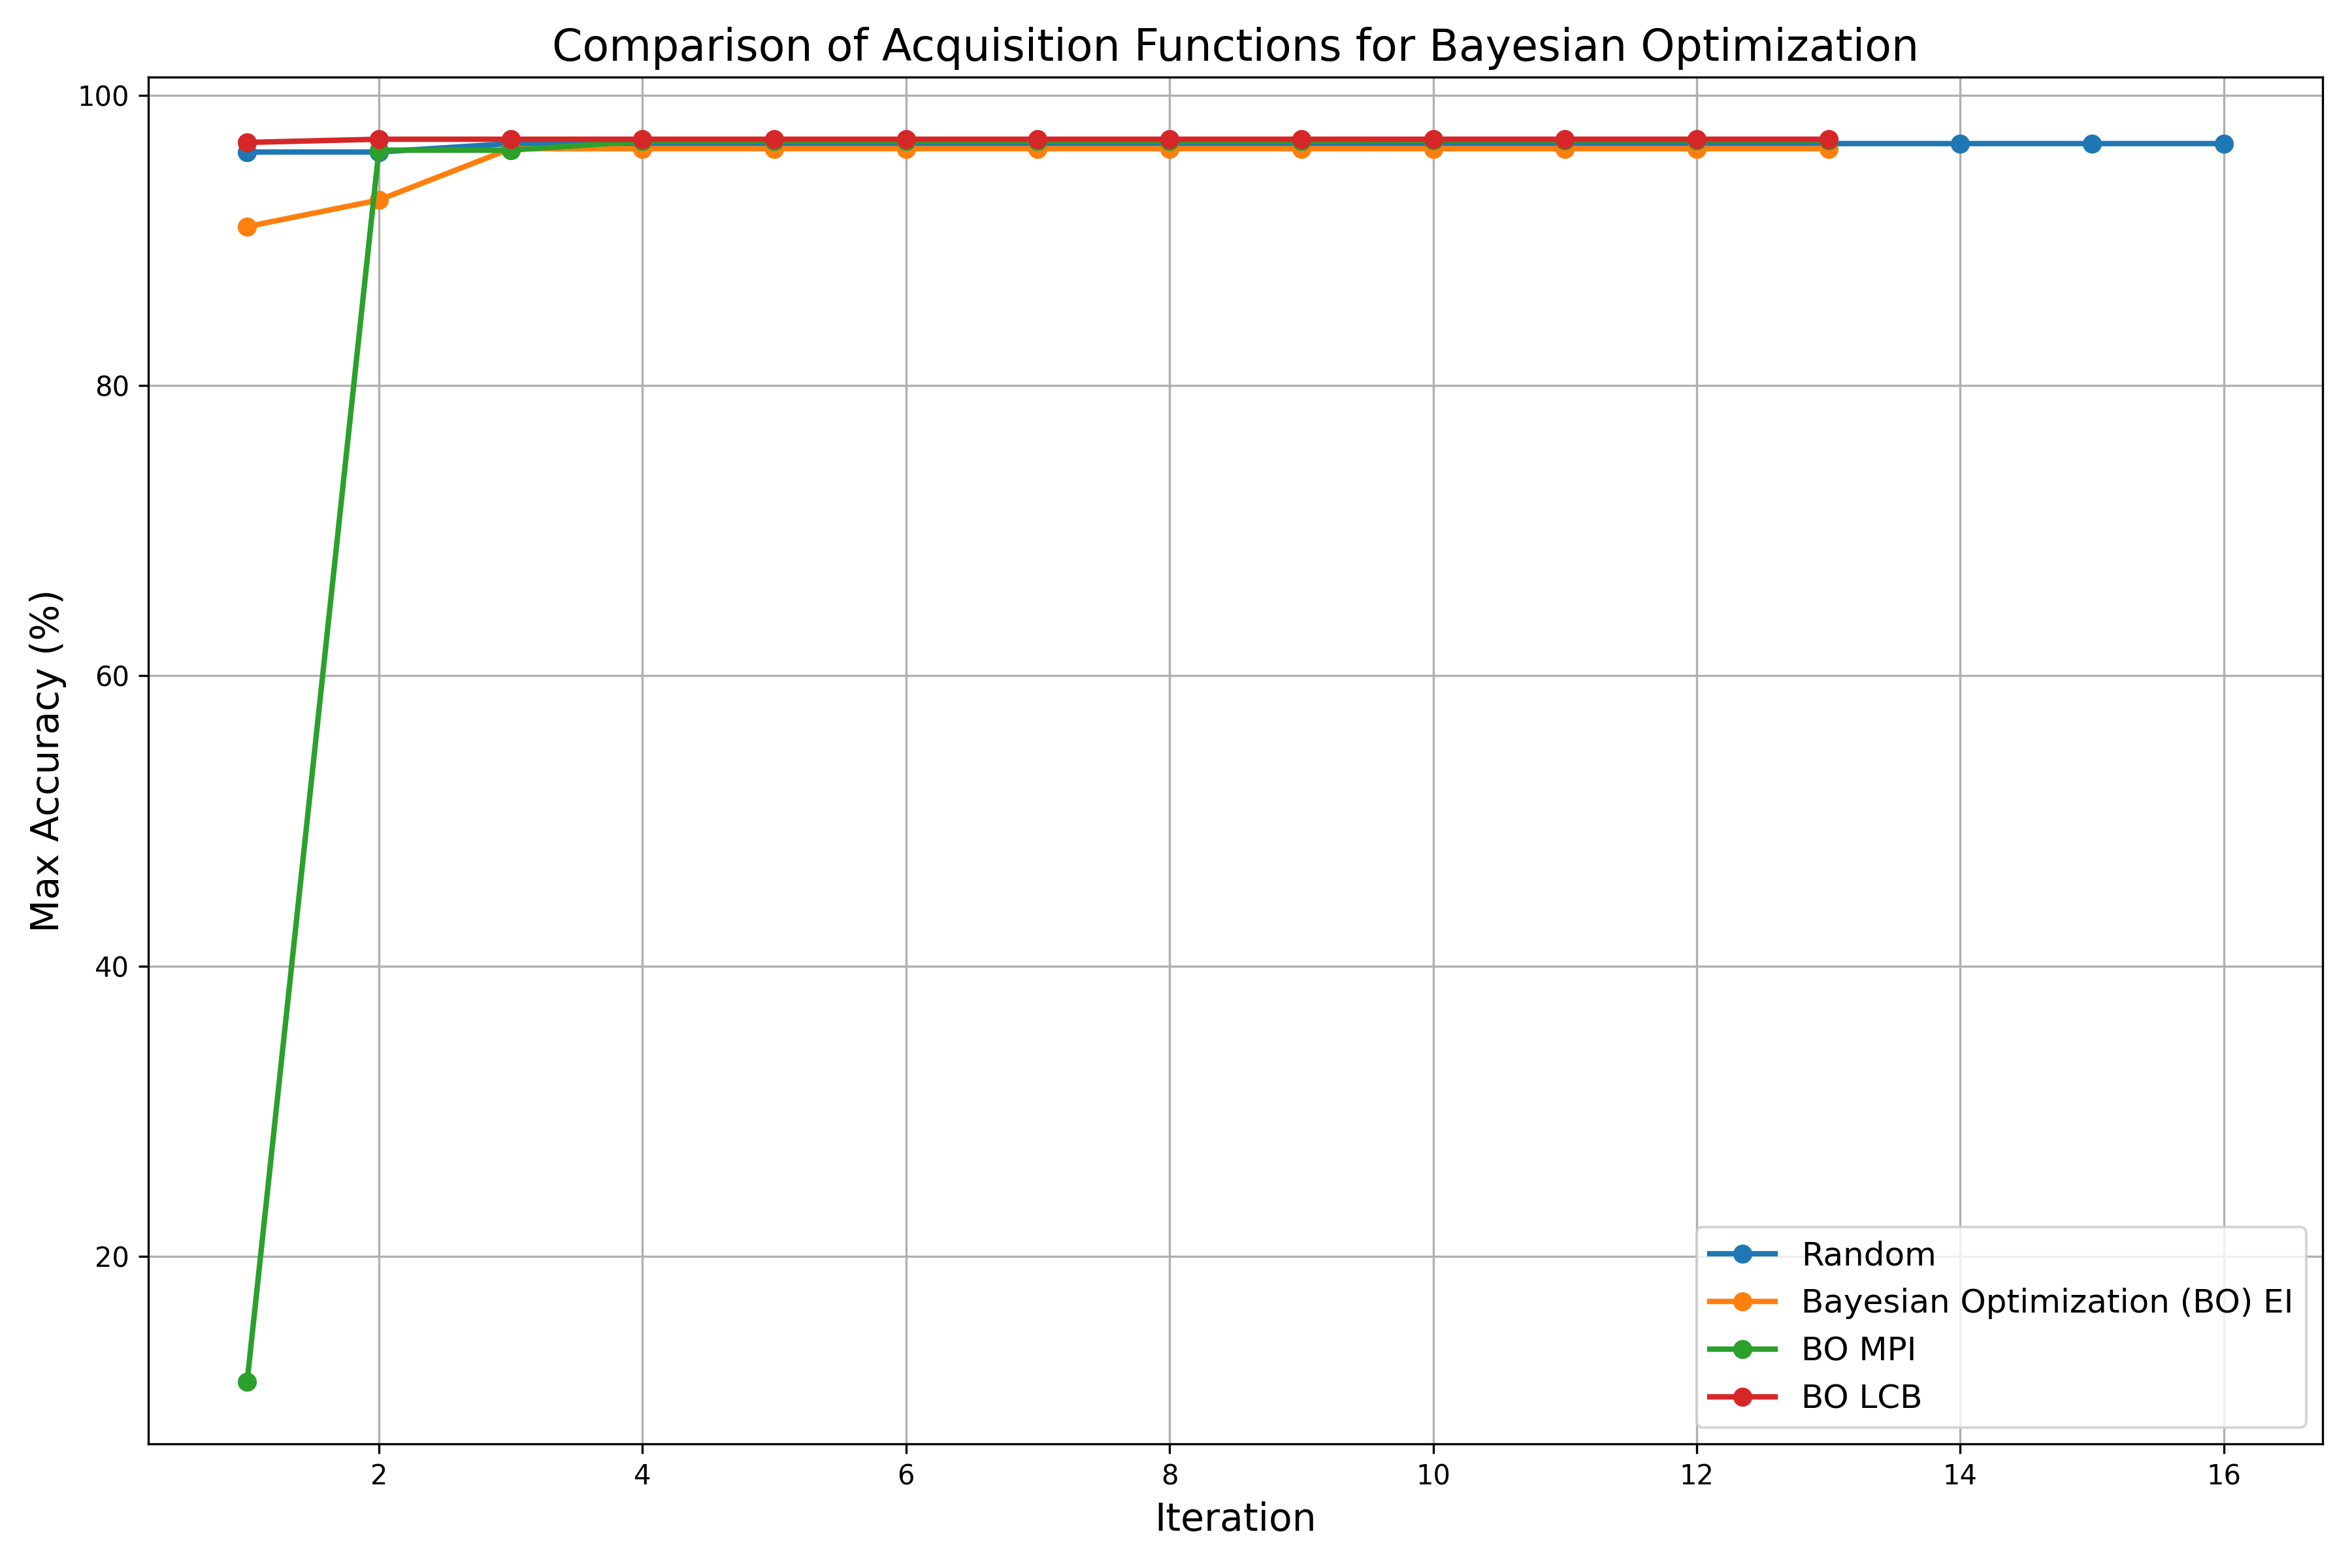

In [28]:
from IPython.display import Image
Image(filename='plots/acquisition_function_comparison.png')